# Thijs Text Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [1]:
!pip install torchtext==0.4

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [3]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/blogtext_full.xlsx'

In [4]:
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)
df = df.drop(['id', 'topic', 'sign', 'date'], axis=1)

df = df.groupby('gender').apply(lambda x: x.sample(frac=0.5))

In [5]:
encoded_gender = []
for gender in df.gender:
  if gender == 'female':
    encoded_gender.append(0)
  if gender == 'male':
    encoded_gender.append(1)

df['gender'] = encoded_gender
df.head()

gender  age                                               text
gender                                                                       
female 41476        0   14          yay! i finally got my shirt. i so happ...
       115443       0   15  My Top Ten Favorite Songs  in no order  &nbsp;...
       435773       0   26               Apparently I blog like a boy.  I ...
       69511        0   14           hey guys whats up not too much me and...
       377655       0   24               happy new years everyone!!!

In [6]:
df

gender  age                                               text
gender                                                                       
female 41476        0   14          yay! i finally got my shirt. i so happ...
       115443       0   15  My Top Ten Favorite Songs  in no order  &nbsp;...
       435773       0   26               Apparently I blog like a boy.  I ...
       69511        0   14           hey guys whats up not too much me and...
       377655       0   24               happy new years everyone!!!         
...               ...  ...                                                ...
male   22859        1   15             u noe, i actually like this spam st...
       37798        1   15             urlLink    new menu for my website    
       584227       1   26  Bogart boxed set came in yesterday.  The  Malt...
       346502       1   24  Last night I caught an excellent show at Cobb'...
       249519       1   26              urlLink    This is the main room. ...

[338925 rows x 3 columns]

## 3. Create n_grams from the text (Optional)

In [7]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    tokens = [token for token in text.split(" ") if token != ""]
    return tokens

def lowered(s):
    return s.lower()

def remove_html_punct(text):
    # remove html tags
    if text:
        text = BeautifulSoup(text,features="html.parser").get_text()
    
        # remove punctuation
        punc = string.punctuation + "“”‘’—"
        no_punct = [words for words in text if words not in punc]
        words_wo_punct=''.join(no_punct)
        return words_wo_punct.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [8]:
# ngram = 2
# for i, text in enumerate(df['text']):
#   if type(df['text'].iloc[i]) != list:
#     lower = lowered(text)
#     non_alph = remove_nonalph(lower)
#     tokens = tokenize(non_alph)
#     no_stopwords = remove_stopwords(tokens)
#     lemma = lemmatize(no_stopwords)
#     # ngrams = generate_ngrams(lemma, ngram)
#     df['text'].iloc[i] = lemma
# print(df['text'].iloc[0])
# print(df['text'])

df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)


In [9]:
df.index = range(len(df))


In [10]:
df


,gender,age,text
0,0,14,"[yay, i, finally, got, my, shirt, i, so, happy..."
1,0,15,"[my, top, ten, favorite, songs, in, no, order,..."
2,0,26,"[apparently, i, blog, like, a, boy, i, found, ..."
3,0,14,"[hey, guys, whats, up, not, too, much, me, and..."
4,0,24,"[happy, new, years, everyone]"
...,...,...,...
338920,1,15,"[u, noe, i, actually, like, this, spam, stuff,..."
338921,1,15,"[urllink, new, menu, for, my, website]"
338922,1,26,"[bogart, boxed, set, came, in, yesterday, the,..."
338923,1,24,"[last, night, i, caught, an, excellent, show, ..."


In [11]:
print(df)

        gender  age                                               text
0            0   14  [yay, i, finally, got, my, shirt, i, so, happy...
1            0   15  [my, top, ten, favorite, songs, in, no, order,...
2            0   26  [apparently, i, blog, like, a, boy, i, found, ...
3            0   14  [hey, guys, whats, up, not, too, much, me, and...
4            0   24                      [happy, new, years, everyone]
...        ...  ...                                                ...
338920       1   15  [u, noe, i, actually, like, this, spam, stuff,...
338921       1   15             [urllink, new, menu, for, my, website]
338922       1   26  [bogart, boxed, set, came, in, yesterday, the,...
338923       1   24  [last, night, i, caught, an, excellent, show, ...
338924       1   26  [urllink, this, is, the, main, room, by, which...

[338925 rows x 3 columns]


## 4. To GPU

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 5. Initialising Neural Network

In [13]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## 6. Classes preprocessing
Checking the amount of classes and mapping them each to a different unique number 

In [14]:
class_choice = 'gender'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

#fig = go.Figure([go.Bar(x=('10s', '20s', '30s'), y=[classdict['10s'], classdict['20s'], classdict['30s']])])
#fig.show()

[0, 1]
classdict:
{1: 171655, 0: 167270}


In [15]:
# class to number mapping
classlist = list(classdict.keys())
classmap = dict([(y,x) for x,y in enumerate(classlist)])
print('classmap:')
print(classmap)
print('amount of classes')
print(len(classdict))

classmap:
{1: 0, 0: 1}
amount of classes
2


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [16]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 8. Mapping text column to numbers (tensor)

In [18]:
df_copy = df.copy()

for i, text in enumerate(df['text']):
  newtext = []
  for word in text:
    word = word.lower()
    newtext.append(int(wordmap[word]))
  df['text'][i] = torch.tensor(newtext).to(torch.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
train_dataset = []

for index, row in df.iterrows():
  clasn = classmap[row['gender']]
  train_dataset.append(tuple((clasn, row['text'])))

As you can see below the train dataset is now a list with tuples (age, text)

In [20]:
print(train_dataset[0])

(1, tensor([   740,      0,    297,     78,      9,    931,      0,     19,    227,
             6,     12,    479,      3,      8,    461,      6,    322,      0,
            69,      1,  61418,     32,     11,      1, 216801,     43,     11,
            49,      7,    196,     17,     11,    242,     49,      4,   3481,
           282,    160,    366,      1,    265,   4604,    666,    493,      6,
            12,    266,      0,    297,    690,  47111,     59,   3519,    922,
             0,     48,    298,    208,      6,     18,     11,     40,     15,
           183,      6,      8,     30,    142,   5699,     19,     50,      0,
           248,      6,      4,      1,   1259,      0,    331,      2,   4456,
             6,      3,  14276,    257,     17,    146,    429,   7242,      7,
            12,    473,    286,      0,    143,     15,    144,    101,     87,
            54,      2,    182,    208,      6,     19,    221,     42,      5,
             1,   3460,   1340,     

## 9. Run neural network

In [21]:
vocab = len(vocabdict)
embed_dim = 32
n_classes = len(classdict)
BATCH_SIZE = 16
model = TextSentiment(vocab, embed_dim, n_classes).to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/Language, speech and dialogue processing/pan_state.pth'))

In [22]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/gender_Blog_nn_confusion_matrix.png')
    

In [24]:
def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_, last_epoch=False):
    loss = 0
    acc = 0
    predictions = []
    labels = []
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
        pred = output.argmax(1).to('cpu')
        label = cls.to('cpu')
        predictions.extend(pred)
        labels.extend(label)
    if last_epoch == False:
      return loss / len(data_), acc / len(data_)
    else:
      return predictions, labels

Epoch: 1
	Loss: 0.0508(train)	|	Acc: 55.3%(train)
	Loss: 0.0001(valid)	|	Acc: 60.3%(valid)
Epoch: 2
	Loss: 0.0461(train)	|	Acc: 58.9%(train)
	Loss: 0.0001(valid)	|	Acc: 59.7%(valid)
Epoch: 3
	Loss: 0.0437(train)	|	Acc: 61.0%(train)
	Loss: 0.0001(valid)	|	Acc: 54.8%(valid)
Epoch: 4
	Loss: 0.0420(train)	|	Acc: 62.7%(train)
	Loss: 0.0001(valid)	|	Acc: 54.6%(valid)
Epoch: 5
	Loss: 0.0407(train)	|	Acc: 64.1%(train)
	Loss: 0.0001(valid)	|	Acc: 54.6%(valid)
Epoch: 6
	Loss: 0.0397(train)	|	Acc: 65.5%(train)
	Loss: 0.0000(valid)	|	Acc: 59.6%(valid)
Epoch: 7
	Loss: 0.0389(train)	|	Acc: 66.5%(train)
	Loss: 0.0000(valid)	|	Acc: 63.8%(valid)
Epoch: 8
	Loss: 0.0382(train)	|	Acc: 67.4%(train)
	Loss: 0.0001(valid)	|	Acc: 62.1%(valid)
Epoch: 9
	Loss: 0.0376(train)	|	Acc: 68.2%(train)
	Loss: 0.0000(valid)	|	Acc: 67.4%(valid)
Epoch: 10
	Loss: 0.0372(train)	|	Acc: 68.9%(train)
	Loss: 0.0000(valid)	|	Acc: 68.4%(valid)
Epoch: 11
	Loss: 0.0367(train)	|	Acc: 69.6%(train)
	Loss: 0.0000(valid)	|	Acc: 68.8%(vali

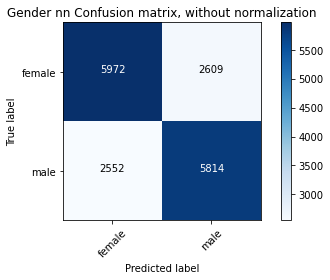

In [25]:
N_EPOCHS = 30
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
#train_len = int(len(train_dataset) * 0.50)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

start_time = time.time()
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    print('Epoch: %d' %(epoch + 1))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    if epoch == (N_EPOCHS-1):
      predictions, labels = test(sub_valid_, True)
      conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1])
      np.set_printoptions(precision=2)
      # Plot non-normalized confusion matrix
      #plt.figure()
      plot_confusion_matrix(conf_matrix, classes=['female','male'], title='Gender nn Confusion matrix, without normalization')

total_time = int(time.time() - start_time)
print('Total time elapsed: %d seconds.' %(total_time))

Normalized confusion matrix
[[0.7  0.3 ]
 [0.31 0.69]]


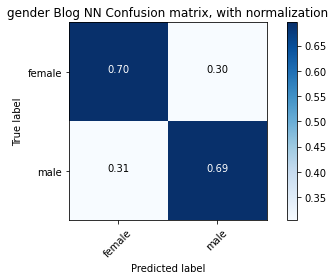

In [26]:
plot_confusion_matrix(conf_matrix, classes=['female', 'male'], normalize=True, title='gender Blog NN Confusion matrix, with normalization')

In [27]:
def predict(text, model, wordmap):
    sentence = []
    for word in text:
      word = word.lower()
      sentence.append(int(wordmap[word]))
    text = torch.tensor(sentence).to(torch.int64)

    with torch.no_grad():
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()



test_text = df_copy['text'][100]

model = model.to("cpu")

inv_map = {v: k for k, v in classmap.items()}
print(inv_map)
print(predict(test_text,model,wordmap))
print("I predict the author of this article is in his/her %a." %inv_map[predict(test_text, model, wordmap)])

{0: 1, 1: 0}
1
I predict the author of this article is in his/her 0.


<function matplotlib.pyplot.plot>

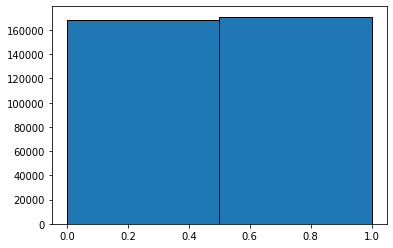

In [28]:
pred_dis = [inv_map[predict(x, model, wordmap)] for x in df_copy['text']]
pred_dict = Counter(pred_dis)

import matplotlib.pyplot as plt
plt.hist(pred_dis, len(pred_dict), edgecolor='black')
plt.plot
